## TensorFlow Core Larning Algorithms

The algorithms we will focus on include:

* Linear Regression
* Classification
* Clustering
* Hidden Markov Models

It is worth nothing that there are many tools within TensorFlow that could be used to slove the problems we will see below. I have chosen the tools that I belive give the most variety are easiest to use.

## Linear Regression

In [4]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np  # Use with multidimentional arrays
import pandas as pd # Use with DataFrame
import matplotlib.pyplot as plt # Use to visualize the data
from IPython.display import clear_output    # Use for clear output
from six.moves import urllib    

import tensorflow.compat.v2.feature_column as fc

import tensorflow as tf

In [14]:
# Survied data from titanic

train_df = pd.read_csv("/Users/ton_kkrongyuth/Deep Learing Practice/Tensorflow/Dataset/train.csv")  # Traning Data
test_df = pd.read_csv("/Users/ton_kkrongyuth/Deep Learing Practice/Tensorflow/Dataset/eval.csv")    # Testing Data
y_train = train_df.pop("survived")
y_test = test_df.pop("survived")

train_df.info(), test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 627 entries, 0 to 626
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 627 non-null    object 
 1   age                 627 non-null    float64
 2   n_siblings_spouses  627 non-null    int64  
 3   parch               627 non-null    int64  
 4   fare                627 non-null    float64
 5   class               627 non-null    object 
 6   deck                627 non-null    object 
 7   embark_town         627 non-null    object 
 8   alone               627 non-null    object 
dtypes: float64(2), int64(2), object(5)
memory usage: 44.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   sex                 264 non-null    object 
 1   age                 264 non-null    fl

(None, None)

In [102]:
train_df.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [20]:
train_df.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [26]:
train_df.shape, test_df.shape

((627, 9), (264, 9))

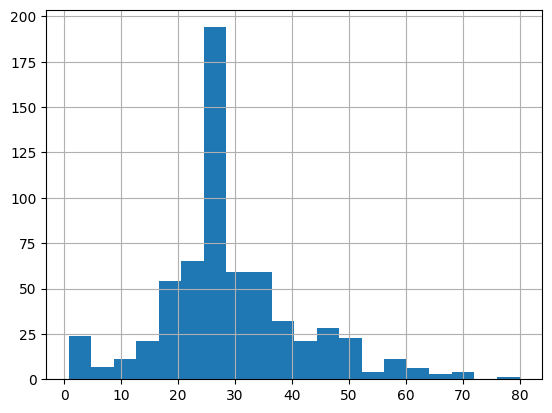

In [28]:
train_df.age.hist(bins = 20);

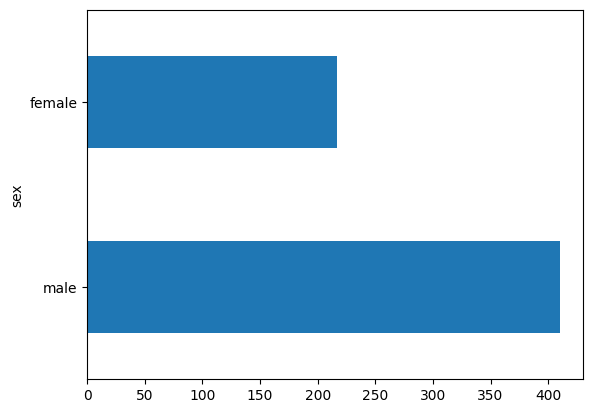

In [31]:
train_df.sex.value_counts().plot(kind = 'barh');

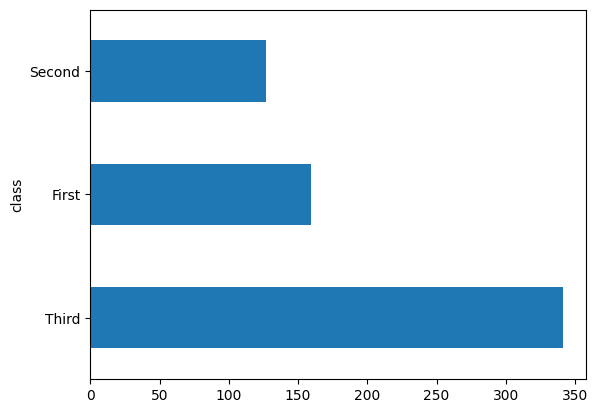

In [34]:
train_df['class'].value_counts().plot(kind = "barh");

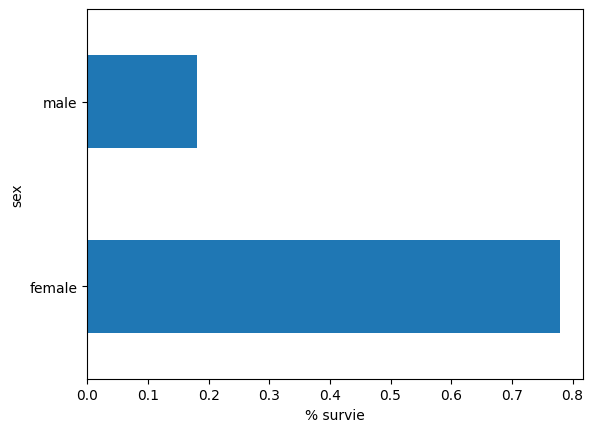

In [54]:
pd.concat([train_df, y_train], axis = 1).groupby('sex')["survived"].mean().plot(kind = 'barh').set_xlabel("% survie");

# Female have higher change to survied

In [69]:
CATAGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck', 'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
feature_columns = []

for feature_name in CATAGORICAL_COLUMNS :
    vocabulary = train_df[feature_name].unique()                                                                # gets a list of all unique values from given feature column --> Turn into discreate value
    print(vocabulary)
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary)) # Encode all of the categorical data

for feature_name in NUMERIC_COLUMNS :
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype = tf.float32))

feature_columns # Create list of all variable in dataframe

['male' 'female']
[1 0 3 4 2 5 8]
[0 1 2 5 3 4]
['Third' 'First' 'Second']
['unknown' 'C' 'G' 'A' 'B' 'D' 'F' 'E']
['Southampton' 'Cherbourg' 'Queenstown' 'unknown']
['n' 'y']


[VocabularyListCategoricalColumn(key='sex', vocabulary_list=('male', 'female'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='n_siblings_spouses', vocabulary_list=(1, 0, 3, 4, 2, 5, 8), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='parch', vocabulary_list=(0, 1, 2, 5, 3, 4), dtype=tf.int64, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='class', vocabulary_list=('Third', 'First', 'Second'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='deck', vocabulary_list=('unknown', 'C', 'G', 'A', 'B', 'D', 'F', 'E'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='embark_town', vocabulary_list=('Southampton', 'Cherbourg', 'Queenstown', 'unknown'), dtype=tf.string, default_value=-1, num_oov_buckets=0),
 VocabularyListCategoricalColumn(key='alone', vocabulary_list=('n', 'y'), dtype=tf.strin

## Training Process
So we are almost done preparing out dataset and i feel as through it's a good time to explain how our model is trained. Specifically how input data is fed to our model.

For this specific model data is going to be streamed into it in small batches of 32. This means we will not feed the entire dataset to our model at once, but simply small batches of entries. We will acutally feed these batches to our model multiple times according to the number of **epoch**

An **epoch** is simply one stream of our entire dataset. The number of epochs we define is the amount of times our model will see the entire dataset. We use multiple epoch in hope that after seeing the same data multiple times the model will better determine how to estimate it.

Ex. if we have 10 epochs, our model will see the same dataset 10 times.

Since we need to feed our data in batches and multiple times we need to create something called an **input function**. The input function simply defines how our dataset will be converted into batches at each epoch. 

## Input Function

The TensorFlow model we are going to use require that the data we pass it comes in as a tf.data.Dataset object. This means we must create a input function that can convert our current pandas Dataframe into that object.

Below you'll see a seemingly complicated input function, this is straight from the TensorFlow documentation (https://www.tensorflow.org/tutorials/estimator/linear). I've commented as much as I can to make it understandble, but you may want to refer to the documentation for a detailed explination of each method.

In [89]:
def make_input_fn(data_df, label_df, num_epoch=10, shuffle=True, batch_size=32) :       # In this case label_df = response
    def input_function() :                                                              # inner function, this will be returned
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))              # create tf.data.Dataset object with data and it's label
        if shuffle:                                                                     
            ds = ds.shuffle(100)                                                        # randomize order of data
        ds = ds.batch(batch_size).repeat(num_epoch)                                     # split dataset into batches of 32 and repeat process for number of epochs
        return ds                                                                       # return a batch of the dataset
    return input_function                                                               # reuturn a function object for use

In [107]:
train_input_fn = make_input_fn(train_df, y_train)
test_input_fn = make_input_fn(test_df, y_test, num_epoch = 1, shuffle = False)

linear_est = tf.estimator.LinearClassifier(feature_columns = feature_columns)

linear_est.train(train_input_fn)
result = linear_est.evaluate(test_input_fn)

clear_output()
result

{'accuracy': 0.7537879,
 'accuracy_baseline': 0.625,
 'auc': 0.83311903,
 'auc_precision_recall': 0.7718406,
 'average_loss': 0.47926968,
 'label/mean': 0.375,
 'loss': 0.47058392,
 'precision': 0.66346157,
 'prediction/mean': 0.38750422,
 'recall': 0.6969697,
 'global_step': 200}

In [108]:
result = list(linear_est.predict(test_input_fn))    # List is use for automatic loop through all the componet in test_input_fn
result
# All the prediction result

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qd/2g4x2ljn7mg77q6tlqd30wf40000gn/T/tmpxe1_w8s_/model.ckpt-200
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([-2.8011262], dtype=float32),
  'logistic': array([0.05726334], dtype=float32),
  'probabilities': array([0.9427366 , 0.05726334], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-0.63693196], dtype=float32),
  'logistic': array([0.3459404], dtype=float32),
  'probabilities': array([0.6540596, 0.3459404], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([0.7277811], dtype=float32),
  'logistic': array([0.6743182], dtype=float32),
  'probabilities': array([0.3256818 , 0.67431813], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {

In [109]:
result[0]["probabilities"] # This is the probabilities of [didn't survied, survied]
test_df.iloc[2], y_test.iloc[2], result[2]["probabilities"] # Information, real value, prediction

(sex                        female
 age                          58.0
 n_siblings_spouses              0
 parch                           0
 fare                        26.55
 class                       First
 deck                            C
 embark_town           Southampton
 alone                           y
 Name: 2, dtype: object,
 1,
 array([0.3256818 , 0.67431813], dtype=float32))

## Classification

Now that we've covered linear regression it is time to talk about classification. Where regression was used to predict a numeric value, classification is used to seperate data points into classes of different labels. In this example we will use a TensorFlow estimator to classify flowers.

This section is based on the following guide from the TensorFlow website. https://www.tensorflow.org/tutorials/estimator/premade

In [110]:
from __future__ import division, absolute_import, print_function, unicode_literals

import tensorflow as tf

import pandas as pd

In [111]:
CSV_COLUMN_NAMES = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth', 'Species']
SPECIES = ['Setosa', 'Versicolor', 'Virginica']
# Lets define some constants to help us later on

In [112]:
train_path = tf.keras.utils.get_file(
    "iris_training.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_training.csv")
test_path = tf.keras.utils.get_file(
    "iris_test.csv", "https://storage.googleapis.com/download.tensorflow.org/data/iris_test.csv")

train = pd.read_csv(train_path, names=CSV_COLUMN_NAMES, header=0)
test = pd.read_csv(test_path, names=CSV_COLUMN_NAMES, header=0)
# Here we use keras (a module inside of TensorFlow) to grab our datasets and read them into a pandas dataframe

573/573 [==============================] - 0s 0us/step


In [115]:
y_train = train.pop("Species")
y_test = test.pop("Species")

In [117]:
train.shape

(120, 4)

## Input Function

In [118]:
def input_fn(data_df, label_df, training=True, batch_size=256) :       
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))         
        if training:                                                                     
            ds = ds.shuffle(100).repeat()                          
        return ds.batch(batch_size)              

In [119]:
feature_columns = []
for key in train.keys():
    feature_columns.append(tf.feature_column.numeric_column(key = key))
feature_columns

[NumericColumn(key='SepalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='SepalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalLength', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 NumericColumn(key='PetalWidth', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)]

## Building the Model

And now we are ready to choose a model. For classification tasks there are variety of different estimators/models that we can pick from. Some options are listed below

* DNNClassifier (Deep Neural Network)
* LinearClassifier

We can choose either model but DNN seems to be the best choice. This is because we may not be able to find a linear coorespondence in out data.

So let's build a model!

In [132]:
# Build a DNN with 2 hidden layers with 30 and 10 hidden nodes each.
classifier = tf.estimator.DNNClassifier(
    feature_columns = feature_columns,
    # Two hidden layers of 30 and 10 nodes respectively.
    hidden_units = [30,10],
    # The model must choose between 3 classes.
    n_classes = 3
)

classifier.train(
    input_fn = lambda: input_fn(train, y_train),
    steps = 5000
)

# input_fn must to be function --> We need to input the function object

# How to use lambda breifly.
x = lambda : print("\n\nTraining Finished!")
x()

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/qd/2g4x2ljn7mg77q6tlqd30wf40000gn/T/tmpziv8eqhz', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INF

In [133]:
classifier.evaluate(input_fn = lambda : input_fn(test, y_test, training = False))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2024-01-03T15:11:22
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qd/2g4x2ljn7mg77q6tlqd30wf40000gn/T/tmpziv8eqhz/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Inference Time : 0.09399s
INFO:tensorflow:Finished evaluation at 2024-01-03-15:11:22
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.93333334, average_loss = 0.73729974, global_step = 5000, loss = 0.73729974
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /var/folders/qd/2g4x2ljn7mg77q6tlqd30wf40000gn/T/tmpziv8eqhz/model.ckpt-5000


{'accuracy': 0.93333334,
 'average_loss': 0.73729974,
 'loss': 0.73729974,
 'global_step': 5000}

In [143]:
def input_fn_pred(features, batch_size = 256) :
    # Convert the inputs to a Dataset without labels.
    return tf.data.Dataset.from_tensor_slices(dict(features)).batch(batch_size)

features = ['SepalLength', 'SepalWidth', 'PetalLength', 'PetalWidth']
predict = {}

print("Please type numeric values as prompted.")
for feature in features :
    valid = True
    while valid :
        val = input(feature + ": ")
        if not val.isdigit(): valid = False
    
    predict[feature] = [float(val)]

predictions = classifier.predict(input_fn = lambda : input_fn_pred(predict))
# Prediction function
for pred_dict in predictions :
    print(pred_dict)
    class_id = pred_dict['class_ids'][0]
    probability = pred_dict['probabilities'][class_id]

    print('Prediction is "{}" ({:.1f}%)'.format(SPECIES[class_id], 100 * probability))

Please type numeric values as prompted.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qd/2g4x2ljn7mg77q6tlqd30wf40000gn/T/tmpziv8eqhz/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
{'logits': array([-0.06512798,  0.25954682, -1.1130043 ], dtype=float32), 'probabilities': array([0.36572936, 0.5060161 , 0.12825459], dtype=float32), 'class_ids': array([1]), 'classes': array([b'1'], dtype=object), 'all_class_ids': array([0, 1, 2], dtype=int32), 'all_classes': array([b'0', b'1', b'2'], dtype=object)}
Prediction is "Versicolor" (50.6%)


## Clustering

Now that we've covered regression and classification it's time to talk about clustering data!

Basic Algorithm for K-Means.

* Step 1: Randomly pick K points to place K centroids
* Step 2: Assign all of the data points to the controids by distance. The closest centroid to a point is the one it is assigned to.
* Step 3: Average all of the points belonging to each centroid to find the middle of those clusters (center of mass). Place the corresponding centroids into that position.
* Step 4: Reassign every point once again to the closest centroid.
* Step 5: Repeat steps 3-4 until no point changes which centroid it belongs to.

Please refer to the video for an explanation of KMeans clustering.

## Hidden Markov Models

"The Hidden Markov Model is a finite set of states, each of which is associated with a (generally multidimensional) probability distribution. Transitions among the states are governed by a set of probabilities called transition probabilities."

(http://jedlik.phy.bme.hu/~gerjanos/HMM/node4.html)

A hidden markov model works with probabilities to predict future events or states. In this section we will learn how to create a hidden markov model that can predict the weather.

This section is based on the following TensorFlow tutorial.

(https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel)

### Data
Let's start by discussing the type of data we use when we work with a hidden markov model. 

In the previous sections we worked with large datasets of 100's of different entries. For a markov model we are only interested in probability distributions that have to do with states. 

We can find these probabilities from large datasets or may already have these values. We'll run through an example in a second that should clear some things up, but let's discuss the components of a markov model.

**States:** In each markov model we have a finite set of states. These states could be something like "warm" and "cold" or "high" and "low" or even "red", "green" and "blue". These states are "hidden" within the model, which means we do not direcly observe them.

**Observations:** Each state has a particular outcome or observation associated with it based on a probability distribution. An example of this is the following: *On a hot day Tim has a 80% chance of being happy and a 20% chance of being sad.*

**Transitions:** Each state will have a probability defining the likelyhood of transitioning to a different state. An example is the following: *a cold day has a 30% chance of being followed by a hot day and a 70% chance of being follwed by another cold day.*

To create a hidden markov model we need.
- States
- Observation Distribution
- Transition Distribution

For our purpose we will assume we already have this information available as we attempt to predict the weather on a given day.

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

### Situation: Weather Model
Taken direclty from the TensorFlow documentation (https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/HiddenMarkovModel). 

We will model a simple weather system and try to predict the temperature on each day given the following information.
1. Cold days are encoded by a 0 and hot days are encoded by a 1.
2. The first day in our sequence has an 80% chance of being cold.
3. A cold day has a 30% chance of being followed by a hot day.
4. A hot day has a 20% chance of being followed by a cold day.
5. On each day the temperature is
 normally distributed with mean and standard deviation 0 and 5 on
 a cold day and mean and standard deviation 15 and 10 on a hot day.

If you're unfamiliar with **standard deviation** it can be put simply as the range of expected values. 

In this example, on a hot day the average temperature is 15 and ranges from 5 to 25. (std = 10)

To model this in TensorFlow we will do the following.


In [4]:
tfd = tfp.distributions # Making the shortcut
initial_distribution = tfd.Categorical(probs = [0.8,0.2]) # Refer to point 2 above
transition_distribution = tfd.Categorical(probs = [[0.7, 0.3], [0.2, 0.8]]) # Refer to points 3 and 4 above
observation_distribution = tfd.Normal(loc = [0.,15.], scale = [5.,10.]) # Refer to points 5 above

# the loc argument represents the mean and the scale is the std.

In [13]:
model = tfd.HiddenMarkovModel(
    initial_distribution = initial_distribution,
    transition_distribution = transition_distribution,
    observation_distribution = observation_distribution,
    num_steps = 7
)
# num_steps --> mean the number of day that we need to predict

In [14]:
mean = model.mean()

# due to the way TensorFlow works on a lower level we need to evaluate part of the graph
# from within a session to see the value of this tensor

# in the new version of tensorflow we need to use tf.compat.v1.Session() rather than just tf.Session()
with tf.compat.v1.Session() as sess:
    print(mean.numpy())

# result --> [3.       6.       7.5      8.25     8.625001 8.812501 8.90625 ]
# It return the prediction of temperature in the next 7 days

[3.       6.       7.5      8.25     8.625001 8.812501 8.90625 ]
